In [25]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline

In [11]:
#Reading data from excel file.
df = pd.read_excel("../../datasets/BTC.xlsx")
print(df.columns)
df.isnull().values.any()

Index(['Date', 'Price', 'Volume', 'Market Cap', 'Velocity', 'Coin Supply'], dtype='object')


False

In [12]:
#Checking the min and max date. 
print("Max Date in dataset", df['Date'].min()
      ,"\nMin Date in dataset ",df['Date'].max())

d0 = df['Date'].min()
d1 = df['Date'].max()
numOfDays = d1 - d0
print("Number of days in the dataset", numOfDays.days)
totalRows = df.shape
print("Number of total record", totalRows)

Max Date in dataset 2014-12-27 00:00:00 
Min Date in dataset  2018-11-15 00:00:00
Number of days in the dataset 1419
Number of total record (1420, 6)


In [14]:
df.describe()

,Price,Volume,Market Cap,Velocity,Coin Supply
count,1420.000000,1.420000e+03,1.420000e+03,1420.000000,1.420000e+03
mean,3065.143289,2.020720e+09,5.139426e+10,6.795194,1.582624e+07
std,3850.149618,3.449144e+09,6.533481e+10,5.427990,1.057295e+06
min,178.100000,7.860650e+06,2.444379e+09,1.340886,1.365563e+07
25%,382.442500,4.871180e+07,5.770533e+09,3.075255,1.497254e+07
50%,770.270000,1.317640e+08,1.235035e+10,3.849472,1.602724e+07
75%,6306.480000,3.377668e+09,1.085434e+11,9.747279,1.670186e+07
max,19497.400000,2.384090e+10,3.265025e+11,16.498825,1.737803e+07


In [15]:
df.head(10)

,Date,Price,Volume,Market Cap,Velocity,Coin Supply
0,2014-12-27,315.86,15185200,4313267197,1.346241,1.365563e+07
1,2014-12-28,317.24,11676600,4333389568,1.345641,1.365966e+07
2,2014-12-29,312.67,12302500,4272268163,1.347260,1.366383e+07
3,2014-12-30,310.74,12528300,4247060095,1.348755,1.366757e+07
4,2014-12-31,320.19,13942900,4377510595,1.350353,1.367160e+07
5,2015-01-01,314.25,8036550,4297535768,1.351008,1.367553e+07
6,2015-01-02,315.03,7860650,4309551126,1.349472,1.367981e+07
7,2015-01-03,281.08,33054400,3846269872,1.352132,1.368390e+07
8,2015-01-04,264.20,55629100,3616320975,1.358539,1.368782e+07
9,2015-01-05,274.47,43962800,3758098008,1.358454,1.369220e+07


In [18]:
## Take the only date and price columns as of now.
df_1=df[['Date','Price']]

In [23]:
df_2 = df_1.set_index('Date')
df_2.index

DatetimeIndex(['2014-12-27', '2014-12-28', '2014-12-29', '2014-12-30',
               '2014-12-31', '2015-01-01', '2015-01-02', '2015-01-03',
               '2015-01-04', '2015-01-05',
               ...
               '2018-11-06', '2018-11-07', '2018-11-08', '2018-11-09',
               '2018-11-10', '2018-11-11', '2018-11-12', '2018-11-13',
               '2018-11-14', '2018-11-15'],
              dtype='datetime64[ns]', name='Date', length=1420, freq=None)

In [26]:
s = sm.tsa.seasonal_decompose(df_2.Price.values, freq=60)

trace1 = go.Scatter(x = np.arange(0, len(s.trend), 1),y = s.trend,mode = 'lines',name = 'Trend',
    line = dict(color = ('rgb(244, 146, 65)'), width = 4))
trace2 = go.Scatter(x = np.arange(0, len(s.seasonal), 1),y = s.seasonal,mode = 'lines',name = 'Seasonal',
    line = dict(color = ('rgb(66, 244, 155)'), width = 2))

trace3 = go.Scatter(x = np.arange(0, len(s.resid), 1),y = s.resid,mode = 'lines',name = 'Residual',
    line = dict(color = ('rgb(209, 244, 66)'), width = 2))

trace4 = go.Scatter(x = np.arange(0, len(s.observed), 1),y = s.observed,mode = 'lines',name = 'Observed',
    line = dict(color = ('rgb(66, 134, 244)'), width = 2))

data = [trace1, trace2, trace3, trace4]
layout = dict(title = 'Seasonal decomposition', xaxis = dict(title = 'Time'), yaxis = dict(title = 'Price, USD'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='seasonal_decomposition')


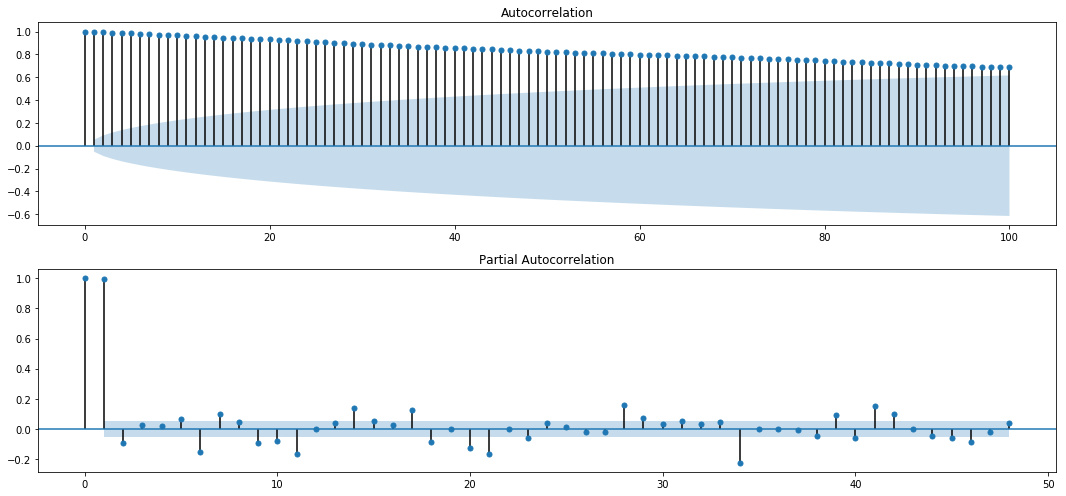

In [34]:
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_2.Price.values.squeeze(), lags=100, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_2.Price.values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [22]:
# Spliting the data. Test data has last 15 days records; rest all are in train data
train_data = df_1[:len(df_1)-15]
test_data =df_1[len(df_1)-15:]
print(len(train_data), len(test_data))

1405 15


In [35]:
def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [46]:
from sklearn.preprocessing import MinMaxScaler

training_set = train_data.Price.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = test_data.Price.values
test_set = np.reshape(test_set, (len(test_set), 1))

#scale datasets
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

# create datasets which are suitable for time series forecasting
look_back = 1
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

 # reshape datasets so that they will be ok for the requirements of the LSTM model in Keras
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

In [49]:
# initialize sequential model, add 2 stacked LSTM layers and densely connected output neuron
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False,
                    validation_data=(X_test, Y_test),
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

Train on 1404 samples, validate on 14 samples
Epoch 1/100
1404/1404 [==============================] - 3s 2ms/step - loss: 0.0065 - val_loss: 0.0028
Epoch 2/100
1404/1404 [==============================] - 1s 848us/step - loss: 0.0189 - val_loss: 0.0066
Epoch 3/100
1404/1404 [==============================] - 1s 840us/step - loss: 0.0241 - val_loss: 0.0152
Epoch 4/100
1404/1404 [==============================] - 1s 853us/step - loss: 0.0169 - val_loss: 0.0069
Epoch 5/100
1404/1404 [==============================] - 1s 859us/step - loss: 0.0076 - val_loss: 0.0027
Epoch 6/100
1404/1404 [==============================] - 1s 857us/step - loss: 0.0030 - val_loss: 5.9990e-04
Epoch 7/100
1404/1404 [==============================] - 1s 852us/step - loss: 0.0012 - val_loss: 1.5547e-04
Epoch 8/100
1404/1404 [==============================] - 1s 867us/step - loss: 6.5573e-04 - val_loss: 9.1073e-05
Epoch 9/100
1404/1404 [==============================] - 1s 875us/step - loss: 4.9611e-04 - val_loss

In [50]:
trace1 = go.Scatter(
    x = np.arange(0, len(history.history['loss']), 1),
    y = history.history['loss'],
    mode = 'lines',
    name = 'Train loss',
    line = dict(color=('rgb(66, 244, 155)'), width=2, dash='dash')
)
trace2 = go.Scatter(
    x = np.arange(0, len(history.history['val_loss']), 1),
    y = history.history['val_loss'],
    mode = 'lines',
    name = 'Test loss',
    line = dict(color=('rgb(244, 146, 65)'), width=2)
)

data = [trace1, trace2]
layout = dict(title = 'Train and Test Loss during training',
              xaxis = dict(title = 'Epoch number'), yaxis = dict(title = 'Loss'))
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='training_process')

In [ ]:
# add one additional data point to align shapes of the predictions and true labels
X_test = np.append(X_test, scaler.transform(train_data.iloc[-1][1]))
X_test = np.reshape(X_test, (len(X_test), 1, 1))

# get predictions and then make some transformations to be able to calculate RMSE properly in USD
prediction = model.predict(X_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

In [54]:
prediction = model.predict(X_test)
print(prediction)

[[0.30448487]
 [0.30491737]
 [0.3038147 ]
 [0.3044179 ]
 [0.30618468]
 [0.3078645 ]
 [0.31067586]
 [0.3075682 ]
 [0.30480295]
 [0.30576083]
 [0.30584404]
 [0.30422074]
 [0.30374292]
 [0.27871165]]
